In [29]:
#https://snap.stanford.edu/data/soc-RedditHyperlinks.html
from google.colab import drive
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
from ipywidgets import interact
import math

In [2]:
drive.mount('/content/gdrive/')
BODY_PATH = "/content/gdrive/My Drive/Colab Notebooks/files/soc-redditHyperlinks-body.tsv"
TITLE_PATH = "/content/gdrive/My Drive/Colab Notebooks/files/soc-redditHyperlinks-title.tsv"

Mounted at /content/gdrive/


In [3]:
df = pd.concat([pd.read_csv(BODY_PATH, delimiter="\t"), pd.read_csv(TITLE_PATH, delimiter="\t")])

In [4]:
df.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


In [10]:
def get_month(df, date):
  return df[df["TIMESTAMP"] == date]
#get_month(df, "2014-03")
df["TIMESTAMP"] = df["TIMESTAMP"].apply(lambda x : x[:7])
get_month(df, "2014-03")

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
7,indiefied,aww,1u50pos,2014-03,1,"295.0,256.0,0.749152542373,0.0203389830508,0.0..."
2253,indiefied,askreddit,1vhza9s,2014-03,1,"248.0,235.0,0.778225806452,0.0120967741935,0.0..."
2706,ascensiongame,solforge,1vs3wzs,2014-03,1,"99.0,99.0,0.777777777778,0.020202020202,0.0606..."
5040,indiefied,askreddit,1x2ah4s,2014-03,1,"118.0,118.0,0.771186440678,0.0508474576271,0.0..."
5279,redditsierra,clashofclans,1x71s7s,2014-03,1,"845.0,713.0,0.751479289941,0.010650887574,0.02..."
...,...,...,...,...,...,...
445935,monism,askphilosophy,55gnnjs,2014-03,1,"80.0,72.0,0.825,0.0,0.0875,0.1125,0.0625,10.0,..."
446021,facedeepinpublic,trashyboners,55hljus,2014-03,1,"20.0,18.0,0.8,0.0,0.3,0.15,0.05,4.0,4.0,0.0,4...."
479232,spchan,swarje,5fqte1s,2014-03,1,"30.0,26.0,0.733333333333,0.0,0.4,0.16666666666..."
500540,austiz,videos,5mef0ns,2014-03,1,"29.0,27.0,0.793103448276,0.0,0.241379310345,0...."


In [88]:
def get_top_graph(df, n):
  a = df["SOURCE_SUBREDDIT"]
  b = df["TARGET_SUBREDDIT"]
  c = df["LINK_SENTIMENT"].astype(int)
  degrees = {}
  for i in range(len(a)):
    if a.iloc[i] not in degrees:
      degrees[a.iloc[i]] = 1
    else:
      degrees[a.iloc[i]] += 1
    if b.iloc[i] not in degrees:
      degrees[b.iloc[i]] = 1
    else:
      degrees[b.iloc[i]] += 1
  top = sorted(degrees.items(), key=lambda x : x[1], reverse=True)
  used = {i[0] for i in top[:min(n, len(top))]}
  name_to_idx = {top[i][0] : i for i in range(min(n, len(top)))}
  matrix = np.full((min(n, len(top)), min(n, len(top))), False)
  G = nx.MultiDiGraph()
  for i in range(len(a)):
    if a.iloc[i] in used and b.iloc[i] in used:
      if G.has_edge(a.iloc[i], b.iloc[i]):
        data = G.get_edge_data(a.iloc[i], b.iloc[i])
        data[0]["weight"] += 1
        data[0]["total_sentiment"] += c.iloc[i]
      else:
        G.add_edge(a.iloc[i], b.iloc[i], weight=1, total_sentiment=c.iloc[i])
      matrix[name_to_idx[a.iloc[i]], name_to_idx[b.iloc[i]]] = True

  return G, matrix, name_to_idx
  
top50, top50_matrix, name_to_idx = get_top_graph(get_month(df, "2014-03"), 200)

In [69]:
def get_min_n(data, n):
  ans = []
  for i in data:
    if len(ans) < n:
      ans.append(i)
    elif i < max(ans):
      ans.append(i)
      ans.remove(max(ans))
  return ans

def get_max_n(data, n):
  ans = []
  for i in data:
    if len(ans) < n:
      ans.append(i)
    elif i > min(ans):
      ans.append(i)
      ans.remove(min(ans))
  return ans

get_max_n([2, 4, 5, 17, 9, 0, 13, -4, 23, 17], 5)

[17, 9, 13, 23, 17]

In [97]:
def get_analytics(df, date, n):
  clear_output()
  G, _, _ = get_top_graph(get_month(df, date), len(df.index))
  in_degree = {i : 0 for i in G.nodes}
  out_degree = {i : 0 for i in G.nodes}
  outgoing_sentiment = {i : 0 for i in G.nodes}
  incoming_sentiment = {i : 0 for i in G.nodes}
  ctr = 0
  edges_weight = []
  edges_sentiment = []
  for e in G.edges:
    in_degree[e[0]] += G.get_edge_data(e[0], e[1])[e[2]]["weight"]
    out_degree[e[1]] += G.get_edge_data(e[0], e[1])[e[2]]["weight"]
    outgoing_sentiment[e[0]] += G.get_edge_data(e[0], e[1])[e[2]]["total_sentiment"]
    incoming_sentiment[e[1]] += G.get_edge_data(e[0], e[1])[e[2]]["weight"]
    edges_weight.append((G.get_edge_data(e[0], e[1])[e[2]]["weight"], e[0] + "->" + e[1]))
    edges_sentiment.append((G.get_edge_data(e[0], e[1])[e[2]]["total_sentiment"], e[0] + "->" + e[1]))
  
  biggest_edges = get_max_n(edges_weight, n)
  biggest_edges_string = "BIGGEST EDGES\n" + "\n".join([str(i) for i in biggest_edges])
  
  nicest_edges = get_max_n(edges_sentiment, n)
  meanest_edges = get_min_n(edges_sentiment, n)
  nicest_edges_string = "NICEST EDGES\n" + "\n".join([str(i) for i in nicest_edges])
  meanest_edges_string = "MEANEST EDGES\n" + "\n".join([str(i) for i in meanest_edges])

  in_degree_list = [(v, k) for k, v in in_degree.items()]
  out_degree_list = [(v, k) for k, v in out_degree.items()]
  total_degree_list = [(in_degree[k] + out_degree[k], k) for k in in_degree.keys()]
  in_sentiment = [(v, k) for k, v in incoming_sentiment.items()]
  out_sentiment = [(v, k) for k, v in outgoing_sentiment.items()]

  avg_in = sum([i[0] for i in in_degree_list]) / len(in_degree_list)
  avg_out = sum([i[0] for i in out_degree_list]) / len(out_degree_list)
  degree_string = "AVERAGE IN DEGREE: " + str(avg_in) + ", AVERAGE OUT DEGREE: " + str(avg_out)

  highest_degree = max(total_degree_list)
  highest_degree_string = "MOST ACTIVE SUBREDDIT: " + str(max(total_degree_list))

  nicest_sub = get_max_n(out_sentiment, n)
  most_loved = get_max_n(in_sentiment, n)
  meanest_sub = get_min_n(out_sentiment, n)
  most_hated = get_min_n(in_sentiment, n)
  in_sentiment_string = "MOST LOVED\n" + "\n".join([str(i) for i in most_loved]) + "\nMOST HATED\n" + "\n".join([str(i) for i in most_hated])
  out_sentiment_string = "NICEST SUBREDDIT\n" + "\n".join([str(i) for i in nicest_sub]) + "\nMEANEST SUBREDDIT\n" + "\n".join([str(i) for i in meanest_sub])
  final_string = [degree_string, highest_degree_string, biggest_edges_string, 
                  nicest_edges_string, meanest_edges_string, in_sentiment_string,
                  out_sentiment_string]
  print("\n".join(final_string))
get_analytics(df, "2014-01", 5)
dates = list({i for i in df["TIMESTAMP"]})
interact(lambda x : get_analytics(df, x, 5), x=dates)

AVERAGE IN DEGREE: 2.7537537537537538, AVERAGE OUT DEGREE: 2.7537537537537538
MOST ACTIVE SUBREDDIT: (650, 'subredditdrama')
BIGGEST EDGES
(13, 'dailydot->iama')
(16, 'atletico->soccer')
(11, 'calgaryflames->hockey')
(12, 'denvernuggets->nba')
(10, 'switcharoo->funny')
NICEST EDGES
(13, 'dailydot->iama')
(10, 'dailydot->explainlikeimfive')
(16, 'atletico->soccer')
(11, 'calgaryflames->hockey')
(12, 'denvernuggets->nba')
MEANEST EDGES
(-3, 'srssucks->subredditdrama')
(-3, 'subredditdrama->anarcho_capitalism')
(-6, 'subredditdrama->relationships')
(-3, 'quityourbullshit->adviceanimals')
(-3, 'mrmorwhiterights->mensrights')
MOST LOVED
(327, 'pics')
(506, 'iama')
(266, 'funny')
(574, 'askreddit')
(217, 'worldnews')
MOST HATED
(0, '4000dollarart')
(0, '100movies365days')
(0, '3dscanning')
(0, '240sx')
(0, '19thworldproblems')
NICEST SUBREDDIT
(145, 'dogecoin')
(160, 'subredditdrama')
(124, 'dailydot')
(371, 'bestof')
(108, 'titlegore')
MEANEST SUBREDDIT
(-3, 'wherearethefeminists')
(-3, 'pa

interactive(children=(Dropdown(description='x', options=('2017-04', '2016-12', '2015-05', '2013-12', '2016-07'…

<function __main__.<lambda>>

In [ ]:
# todo: make the vectors length 1 before applying constant

positions = nx.circular_layout(top50, scale=5)
def update_positions(g, g_matrix, g_dict, positions, n_iters, toward_constant=0.00005, away_constant=0.00005):
  for _ in range(n_iters):
    #force = {i : -0.01 * positions[i] for i in nx.nodes(g)}
    force = {i : 0 for i in nx.nodes(g)}
    for a in nx.nodes(g):
      for b in nx.nodes(g):
        if a == b:
          continue
        elif (positions[a] == positions[b]).all():
          distance = 0.00000001
          dir_ab = np.random.random(size=2) * 2 - 1
          dir_ba = -dir_ab
        else:
          distance = np.linalg.norm(positions[a] - positions[b])
          dir_ab = (positions[a] - positions[b]) / distance
          dir_ba = (positions[b] - positions[a]) / distance
        if g_matrix[g_dict[a], g_dict[b]]:
          weight = g.get_edge_data(a, b)[0]["weight"]
          force[a] += weight * toward_constant * distance * dir_ba
          force[b] += weight * toward_constant * distance * dir_ab
        
        force[a] -= (away_constant / (distance ** 2)) * dir_ba
        force[b] -= (away_constant / (distance ** 2)) * dir_ab
    for k in positions.keys():
      #positions[k] = np.minimum(1, np.maximum(-1, positions[k] + force[k]))
      positions[k] = positions[k] + force[k]
  return positions
pos = update_positions(top50, top50_matrix, name_to_idx, positions, 50)
plt.figure(1, figsize=(12, 12))
nx.draw_networkx(top50, pos=pos, edgelist=[], node_size=50)

In [ ]:
pos = update_positions(top50, top50_matrix, name_to_idx, pos, 50)
plt.figure(1, figsize=(24, 24))
nx.draw_networkx(top50, pos=pos, edgelist=[], node_size=50)

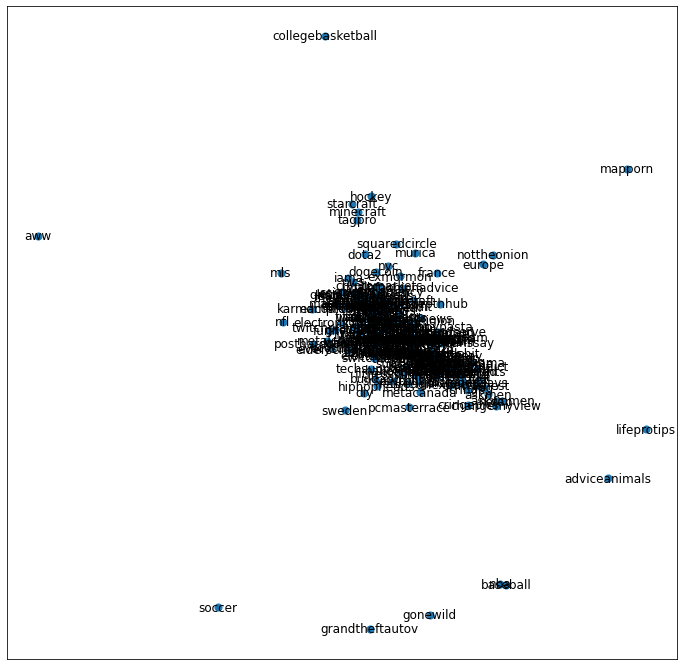

In [98]:
plt.figure(1, figsize=(12, 12))
nx.draw_networkx(top50, pos=nx.spring_layout(top50, pos=nx.kamada_kawai_layout(top50, scale=1), iterations=50, scale=2), edgelist=[], node_size=50)

In [52]:
t_g:nx.MultiDiGraph = nx.MultiDiGraph()
t_g.add_edge("a", "b", weight=1)
t_g.get_edge_data("a", "b")[0]["weight"] = 2
t_g.get_edge_data("a", "b")
t_g.add_edge("b", "c", weight=1)
t_g.get_edge_data("b", "c")
t_g.edges

OutMultiEdgeView([('a', 'b', 0), ('b', 'c', 0)])